## Цели

Ознакомиться, проанализировать и получить навыки реализации модели линейной рециркуляционной сети (autoencoder) для задачи сжатий графической информации

In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from os.path import join as pjoin
from functools import partial
from tqdm import tqdm
from IPython.core.display import Image, display

### Генерация данных

Для проверки гипотез использовался датасет VOC2012, каждая картинка которого предварительно ресайзнута до размера 256х256 и сконвертированна в изображение в оттенках серого. Первый генератор берет одну рандомную картинку из датасета и всегда ее одну же возвращает. Второй возвращает рандомную картинку из этого же датасета.

In [2]:
gen_img_path = None
def generator(path,
              size=256,
              is_test=False):
    global gen_img_path
    image_paths = [pjoin(path, img_path) for img_path in os.listdir(path)]
    img_path = random.choice(image_paths)
    gen_img_path = img_path
    img = cv2.imread(img_path, 0) #read grayscale
    img = cv2.resize(img, (size, size))
    img = 2*img/255 - 1
    while 1:
        yield img.copy()
            

In [3]:
def generator2(path,
              size=256,
              is_test=False):
    images = [cv2.resize(cv2.imread(pjoin(path, img_path), 0), (size, size)) for img_path in tqdm(os.listdir(path))]
    while 1:
        img = random.choice(images)
        img = 2*img/255 - 1
        yield img

In [4]:
dataset_path = "VOCdevkit/VOC2012/JPEGImages/"
#dataset_path = "mnist/all"
gen = generator(dataset_path)
gen2 = generator2(dataset_path)
dataset_size = len(os.listdir(dataset_path))

### Autoencoder

Создаем класс Autoencoder, который принимает картинку grayscale размером 256x256, разбивает ее на кропы размером 16x16 (или другие, указывает пользователь) и коеффициент сжатия z, и на основе этого создает обучаемую модель.

* use_adapt_lr - Флаг, указывающий, использовать ли адаптивный learning rate

* use_norm - Флаг, указывающий, нормализовывать ли веса после их обновления

In [5]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder():
    def __init__(self,
                 input_size=256,
                 crop_size=16,
                 z=0.5,
                 lr=1e-3,
                 use_adapt_lr=False,
                 use_norm=False,
                 phase='train'):
        self.input_layers = crop_size*crop_size
        self.mid_layers = int(z*self.input_layers)
        self.input_size=input_size
        self.crop_size=crop_size
        if self.input_size % self.crop_size != 0:
            raise ValueError("incorrect input data")
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.phase=phase
        self.lr = lr
        self.use_adapt_lr = use_adapt_lr
        self.use_norm = use_norm
        self.loss = lambda x, y: ((x - y) ** 2)
        self.build()
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.initializer(size=[self.mid_layers, self.input_layers])
    
    def __call__(self, inp):
        err = []
        results = []
        size = self.input_size
        crop_size = self.crop_size
        parts = inp.reshape([size, size//crop_size, crop_size]).transpose(1, 0, 2) \
               .reshape((size//crop_size)**2, crop_size, crop_size)
        for part in parts:
            inp_part = np.expand_dims(part.flatten(), 0)
            mid, res = self.forward(inp_part)
            results.append(res.flatten().reshape(crop_size, crop_size))
            if self.phase == 'train':
                diff = res-inp_part
                err.append((diff*diff).sum())
                self.backward(inp_part, mid, diff)
        if self.phase == 'train':
            return np.sum(err)
        else:
            return np.array(results).reshape(size//crop_size, size, crop_size).transpose(1,0,2).reshape(size, size)
        
    
    def forward(self, inp):
        mid = self.encode(inp)
        return mid, self.decode(mid)
    
    def backward(self, inp, mid, err):
        lr = 1/np.dot(inp, inp.T)**2 if self.use_adapt_lr else self.lr
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        
        lr = 1/np.dot(mid, mid.T)**2 if self.use_adapt_lr else self.lr
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.use_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)
                          
    def encode(self, inp):
        return np.dot(inp, self.W1)
    
    def decode(self, mid):
        return np.dot(mid, self.W2)
    
    def get_weights(self):
        return [self.W1.copy(), self.W2.copy()]
    
    def set_weights(self, weights):
        self.W1, self.W2 = weights
    
    def eval(self):
        self.phase = 'test'

In [6]:
def get_image(path, img_path=None, size=256):
    image_path = random.choice([pjoin(dataset_path, img_path) for img_path in os.listdir(path)]) if img_path is None else img_path
    return cv2.resize(cv2.imread(image_path, 0), (size, size))

In [7]:
def predict(model, path=None):
    img = get_image(dataset_path, img_path=path)
    
    h, w = img.shape
    
    res = model(img)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(res, cmap='gray')

### Обучение

Проверяем при каком подборе гиперпараметров будет оптимально сходиться, результаты на графике

In [11]:
def train_single_image(use_norm=True, use_adapt_lr=True, z=0.75):
    model = Autoencoder(use_norm=use_norm, use_adapt_lr=use_adapt_lr, z=z)
    errors = []
    it_count = 300
    best_weights = None
    best_error = np.inf
    for it in tqdm(range(it_count)):
        inp = next(gen)
        err = model(inp)
        errors.append(err)
        if err < best_error:
            best_error = err
            best_weights = model.get_weights()
            #print(best_error)

    x = np.arange(len(errors))
    plt.xlabel("iterations")
    plt.ylabel("error")
    plt.plot(x, np.array(errors))
    idx = np.argmin(errors)
    print("BEST ERROR {}".format(errors[idx]))
    plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
    
    model.eval()
    model.set_weights(best_weights)
    assert gen_img_path is not None
    predict(model, gen_img_path)
    
    plt.show()

100%|██████████| 300/300 [00:53<00:00,  4.73it/s]


BEST ERROR 109.102321700584


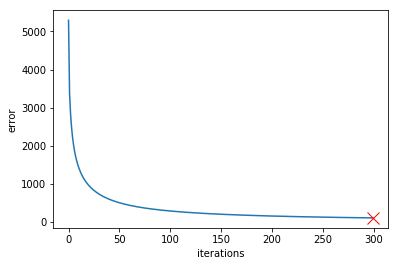

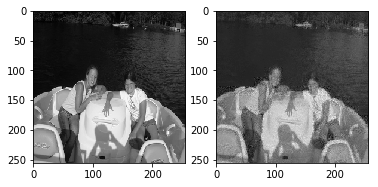

100%|██████████| 300/300 [01:03<00:00,  5.11it/s]


BEST ERROR 333.76014298948115


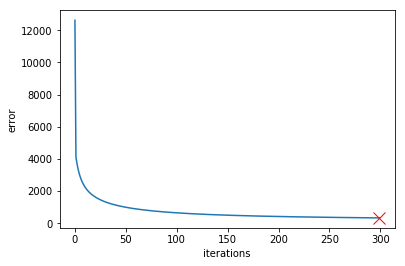

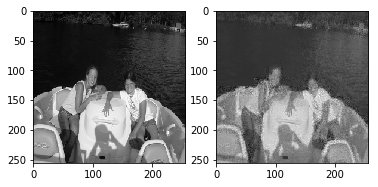

100%|██████████| 300/300 [01:29<00:00,  2.77it/s]


BEST ERROR 113.12394945403753


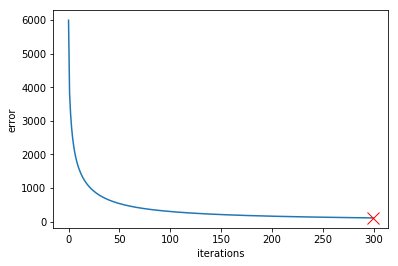

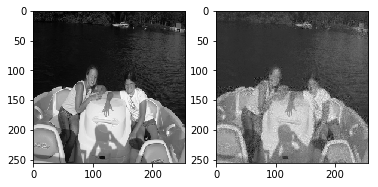

100%|██████████| 300/300 [01:28<00:00,  3.37it/s]


BEST ERROR 420.5032600763484


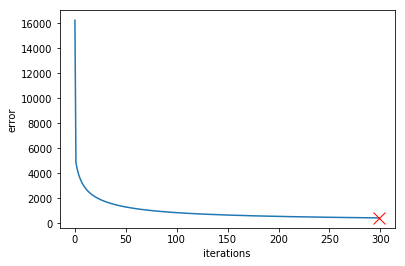

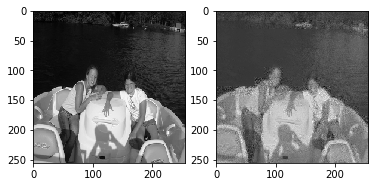

In [12]:
for use_norm in [False, True]:
    for use_adapt_lr in [False, True]:
        train_single_image(use_norm, use_adapt_lr)

100%|██████████| 300/300 [01:05<00:00,  4.37it/s]

BEST ERROR 511.7068906277251


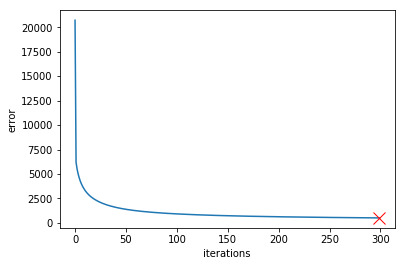

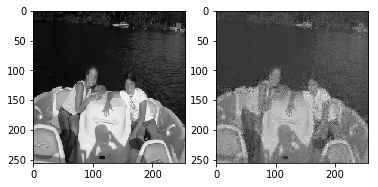

100%|██████████| 300/300 [01:15<00:00,  3.86it/s]


BEST ERROR 447.07394482825885


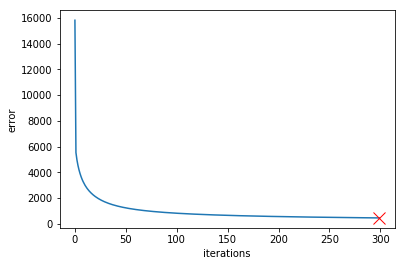

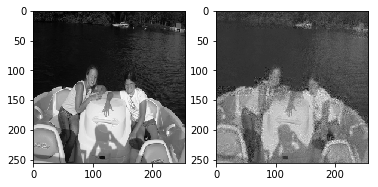

100%|██████████| 300/300 [01:24<00:00,  3.64it/s]


BEST ERROR 471.8904240475643


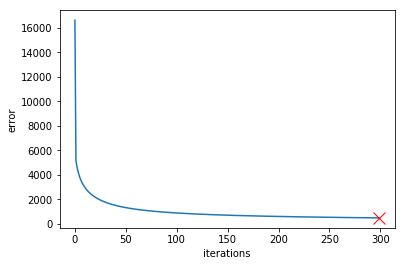

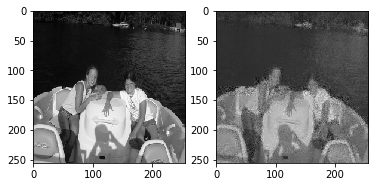

100%|██████████| 300/300 [01:32<00:00,  3.36it/s]

BEST ERROR 428.03413426682295


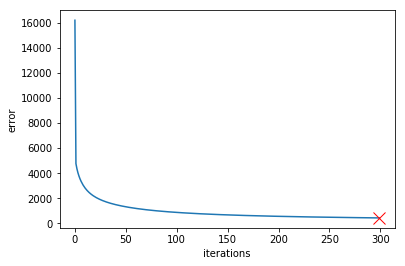

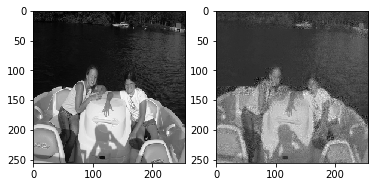

In [13]:
for z in [0.5, 0.6, 0.7, 0.8]:
    train_single_image(z=z)

### Обучение

Обучаем на множестве картинок.

EPOCH 0 MSE 400.11662145870554
BEST ERROR 400.11662145870554


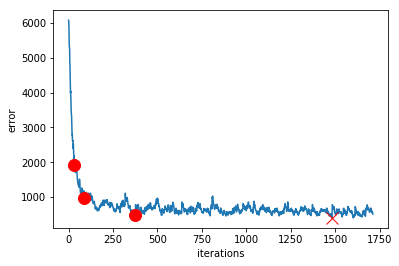

In [20]:
model = Autoencoder()
epochs = 1
momentum = 0.9
errors=[]
best_weights = None
best_error = np.inf
for epoch in range(epochs):
    moving_err = None
    for it in range(dataset_size//10):
        inp = next(gen2)
        err = model(inp)
        moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
        if moving_err < best_error:
            best_error = moving_err
            best_weights = model.get_weights()
            #print("Weights updated {}".format(best_error))
        errors.append(moving_err)
    print("EPOCH {} MSE {}".format(epoch, best_error))

errors = np.array(errors)
x = np.arange(len(errors))
plt.xlabel("iterations")
plt.ylabel("error")
plt.plot(x, errors)

idx = np.argmin(errors)
print("BEST ERROR {}".format(errors[idx]))
plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)

for eps in [2000, 1000, 500]:
    idx = np.argwhere(errors < eps)[0][0]
    plt.plot(x[idx], errors[idx], 'ro--', linewidth=2, markersize=12)
plt.show()

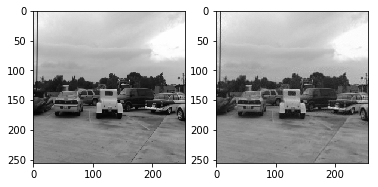

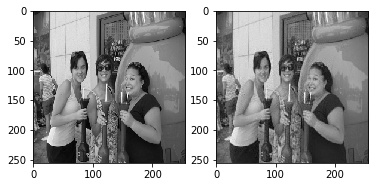

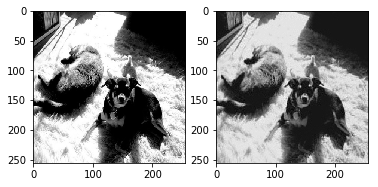

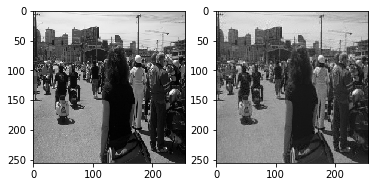

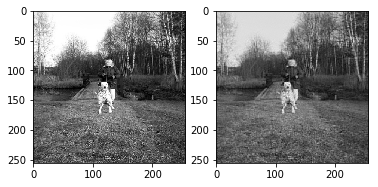

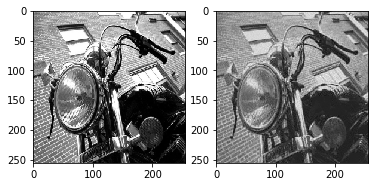

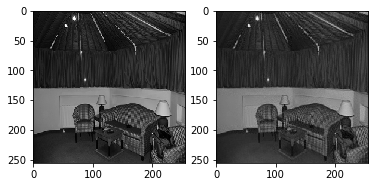

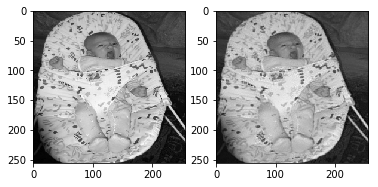

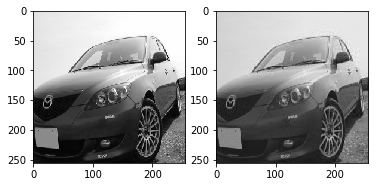

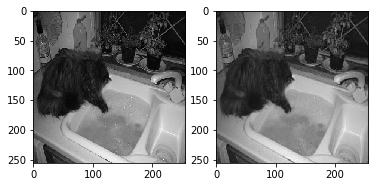

In [21]:
for _ in range(10):
    model.eval()
    model.set_weights(best_weights)
    predict(model)

In [22]:
np.save('w1.h5', best_weights[0])
np.save('w2.h5', best_weights[1])

### Выводы

В данной лабораторной работе я научился сжимать изображения с помощью модели линейной рециркуляционной сети. На практике использование нормализации весов после их обновления и адаптивный learning_late поспособствовали более медленному схождению, чем просто использовать статический learning rate и не использовать нормализацию весов. Также заметим, что тем больше z, тем быстрее и точнее сходится модель. Подтверждающие графики и результаты приведены выше.